In [1]:
import librosa
from IPython.display import Audio
import tensorflow as tf
from models.vqvae2 import *
from IPython import display
import matplotlib.pyplot as plt

import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import os 
import librosa.display
import numpy as np
from kapre.time_frequency import STFT, InverseSTFT, Magnitude, Phase, MagnitudeToDecibel

In [2]:
vqvae_trainer = VQVAETrainer(latent_dim=None, num_embeddings=None)
vqvae_trainer.load_weights("../new_vae/saved_models/audio_restor_model_1")
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())

Metal device set to: Apple M1 Pro


2021-12-03 09:39:25.529487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-03 09:39:25.529616: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [93]:
from utils.echo import convolve_with_room, get_room_irs

In [94]:
irs = get_room_irs(10)

getting irs


/Users/llewyn/miniforge3/lib/python3.9/site-packages/pyroomacoustics/room.py:988: UserWarning: The number of rays used for ray tracing is larger than100000 which may result in slow simulation.  The numberof rays was automatically chosen to provide accurateroom impulse response based on the room volume and thereceiver radius around the microphones.  The number ofrays may be reduced by increasing the size of thereceiver.  This tends to happen especially for largerooms with small receivers.  The receiver is a spherearound the microphone and its radius (in meters) may bespecified by providing the `receiver_radius` keywordargument to the `set_ray_tracing` method.
  warnings.warn(
/Users/llewyn/Documents/projects/mir/daniil2/src/utils/echo.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creat

In [41]:
clean, sr = librosa.load("/Users/llewyn/Documents/recordings/widmung-clean.m4a", sr=44100)
noised, sr =  librosa.load("/Users/llewyn/Documents/recordings/widmung-noised.wav", sr=44100)

/Users/llewyn/miniforge3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [103]:
clean_ex = clean[0 : 10 * sr]
noised_ex = convolve_with_room(clean_ex, irs[0])[0 : 10 * sr]

In [104]:
Audio(clean_ex, rate=sr)

In [105]:
Audio(noised_ex, rate=sr)

In [106]:
clean_ex_stft = librosa.stft(clean_ex)
noised_ex_stft = librosa.stft(noised_ex)

In [134]:
mag = np.abs(noised_ex_stft) + np.abs(clean_ex_stft)
clean_ex_phase = np.angle(clean_ex_stft)
noised_clean = P2R(mag, clean_ex_phase)

In [135]:
Audio(librosa.istft(noised_clean), rate=44100)

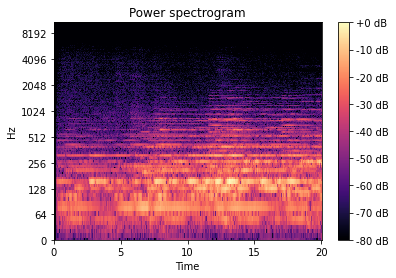

In [133]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(mag,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

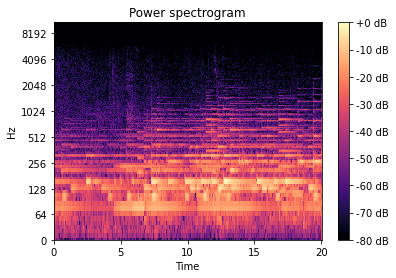

In [109]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(clean_ex_stft,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

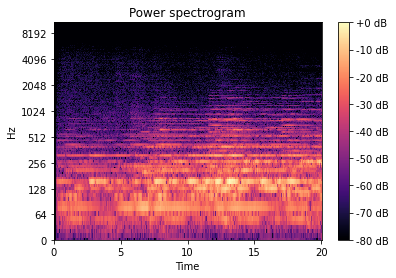

In [110]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(noised_ex_stft,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

# Helpers

In [2]:
def P2R(radii, angles):
    return radii * np.exp(1j*angles)

# This should invert the results of audio_stfts
def reconstruct_audio(chunked_mag, chunked_angle, scaling_factor=-80.):  
    chunked_mag, chunked_angle = chunked_mag.squeeze(3), chunked_angle.squeeze(3)
        
    db, angles = concat_stft(chunked_mag * scaling_factor), concat_stft(chunked_angle)
    db, angles = np.swapaxes(db, 0, 1), np.swapaxes(angles, 0, 1)
    stfts = P2R(librosa.db_to_amplitude(db), angles)
    audio = librosa.istft(stfts)
    return audio

def chunk_stft(stft, chunk_size=88):
    new_stft = np.zeros((stft.shape[0] // chunk_size, chunk_size, stft.shape[1]))
    for i in range(0, stft.shape[0], chunk_size):
        chunk_index  = i // chunk_size
        new_stft[chunk_index, :, :] = stft[i : i + chunk_size, :]
    return new_stft

def concat_stft(chunked_stft, chunk_size=88):
    stft = np.zeros((chunked_stft.shape[0] * chunked_stft.shape[1], chunked_stft.shape[2]))
    
    for i in range(0, chunked_stft.shape[0]):
        stft[i * chunk_size : i*chunk_size + chunk_size,:] = chunked_stft[i, :, :]
    
    return stft

def kapre_stft(x):
    x = np.expand_dims(x, 0)
    x = np.expand_dims(x, 2)
    STFT_Layer = STFT(n_fft=2048, win_length=2048, hop_length=512,
                   window_name=None, pad_end=False, pad_begin=True,
                   input_data_format='channels_last', output_data_format='channels_last',
                   input_shape=(len(x), 1))
    ISTFT_Layer = InverseSTFT(n_fft=2048, hop_length=512, 
            input_shape=(88, 1024, 1))
    Mag_Layer = Magnitude()
    Phase_Layer = Phase()
    Decibel_Layer = MagnitudeToDecibel()
    
    stft = STFT_Layer(x)
    mag = Mag_Layer(stft)
    dec = Decibel_Layer(tf.math.square(mag)) / 80.
    angle = Phase_Layer(stft)
    
    dec = dec.numpy().reshape(dec.shape[1], dec.shape[2])
    angle = angle.numpy().reshape(angle.shape[1], angle.shape[2])
    
    chunk_length = 88
    if dec.shape[0] % 88 != 0:
        multiple = np.ceil(dec.shape[0] / chunk_length)
        pad_amount = chunk_length * multiple - dec.shape[0]
        dec = np.pad(dec, ((0, int(pad_amount)),(0,0)), 'constant', constant_values=(0, 0))
        angle = np.pad(angle, ((0,int(pad_amount)),(0,0)), 'constant', constant_values=(0, 0))
    
    chunked_dec, chunked_angle = chunk_stft(dec), chunk_stft(angle)
    
    chunked_dec, chunked_angle = chunked_dec[:, :, :-1, np.newaxis], chunked_angle[:, :, :-1, np.newaxis]
    return chunked_dec, chunked_angle

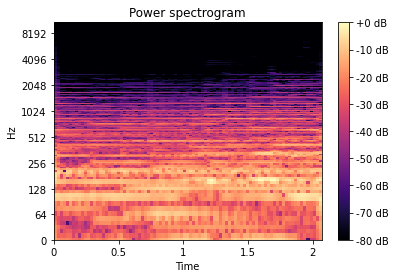

In [25]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(etude[10 * sr : 10*sr + 2048 * 22])),
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")